In [1]:
import sys
sys.path.append('../code/functions')
sys.path.append('/home/simpleElastix/build/SimpleITK-build/Wrapping/Python')

import pickle
import cv2

import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

from tiffIO import loadTiff, unzipChannels
from connectLib import adaptiveThreshold

# Load Data

In [2]:
tp1ChanList = unzipChannels(loadTiff('../data/SEP-GluA1-KI_tp1.tif'))

In [3]:
tp2ChanList = unzipChannels(loadTiff('../data/SEP-GluA1-KI_tp2.tif'))

In [ ]:
print tp1ChanList.shape
print tp2ChanList.shape

In [4]:
tp1Test = tp1ChanList[1][15:20]
tp2Test = tp2ChanList[1][15:20]

In [ ]:
print tp1Test.shape
print tp2Test.shape

In [ ]:
fig = plt.figure()
plt.imshow(tp1Test[0], cmap='gray')
plt.title('TP1 at z=10')
plt.show()

In [ ]:
fig = plt.figure()
plt.imshow(tp2Test[0], cmap='gray')
plt.title('TP2 at z=10')
plt.show()

# Visualization Functions

In [5]:
def toDiff(imgA, imgB):
    ret = np.empty((imgA.shape[0], imgA.shape[1], 3), dtype=np.uint8)
    for y in range(imgA.shape[0]):
        for x in range(imgA.shape[1]):
            
            if imgA[y][x] and not imgB[y][x]:
                ret[y][x][0] = 255
                ret[y][x][1] = 0
                ret[y][x][2] = 0
            elif not imgA[y][x] and imgB[y][x]:
                ret[y][x][0] = 0
                ret[y][x][1] = 255
                ret[y][x][2] = 0
            elif imgA[y][x] and imgB[y][x]:
                ret[y][x][0] = 255
                ret[y][x][1] = 0
                ret[y][x][2] = 255
            else:
                ret[y][x][0] = 255
                ret[y][x][1] = 255
                ret[y][x][2] = 255
            
    return ret

def visDiff(sliceA, sliceB):
    disp = toDiff(sliceA, sliceB)
    return disp

def visVolDiff(volumeA, volumeB):
    for i in range(volumeA.shape[0]):
        plt.figure()
        plt.title('Disperity at z=' + str(i))
        plt.imshow(visDiff(volumeA[i], volumeB[i]))
        plt.show()

# Strategy
First order of business is getting something that is an improvement on what we have currently. This should be simple; as what we have currently takes virtually forever to run.

I think the place to start is cleaning up the input images so the registration actually has something to hold on to

In [6]:
def preproc(img):
    binImg = adaptiveThreshold(img, 5, 5)
    return binImg

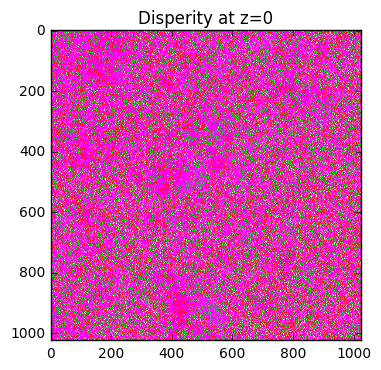

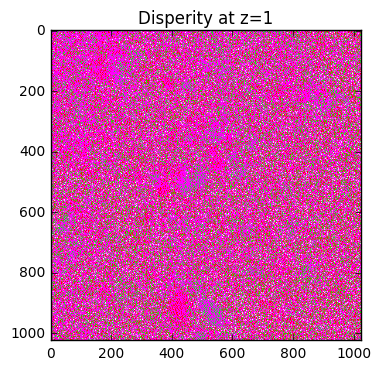

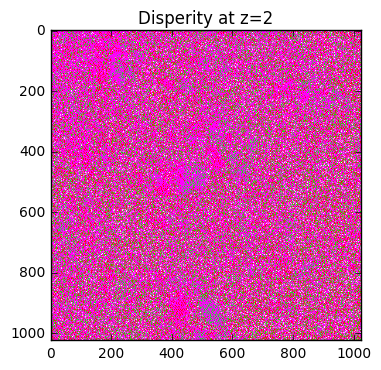

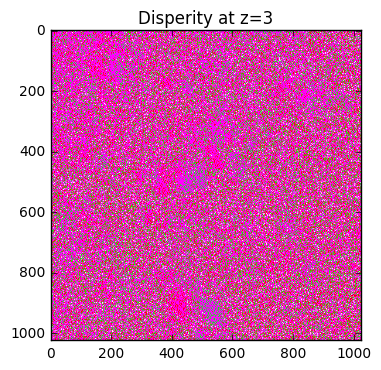

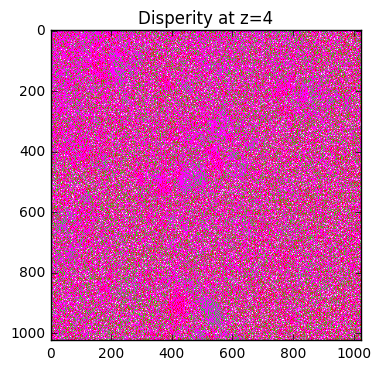

In [11]:
visVolDiff(tp1Test, tp2Test)

0.2
0.4
0.6
0.8
1.0
0.2
0.4
0.6
0.8
1.0


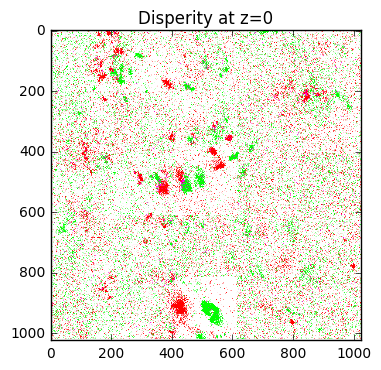

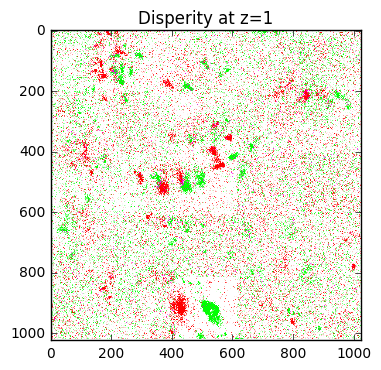

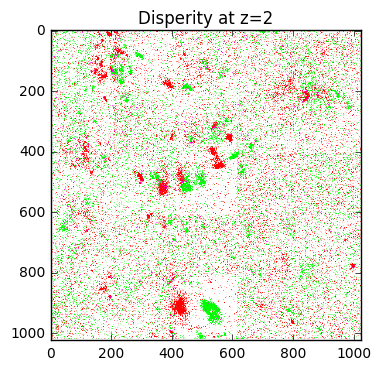

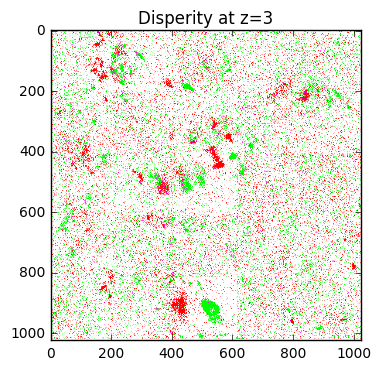

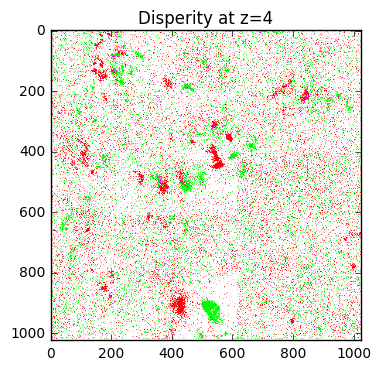

In [12]:
visVolDiff(preproc(tp1Test), preproc(tp2Test))

Now, that looks better. As a human I can now see how the images should pair, so (hopefully) this allows simple elastix to as well.

I plan to start simple - just a rigid transform with a low number of required valid samples to see where it gets us

In [37]:
%%time

SimpleElastix = sitk.SimpleElastix()

SimpleElastix.LogToConsoleOn()

img2 = nib.Nifti1Image(preproc(tp1Test), np.eye(4))
nib.save(img2, 'fixed.nii')
img3 = nib.Nifti1Image(preproc(tp2Test), np.eye(4))
nib.save(img3, 'moving.nii')

SimpleElastix.SetFixedImage(sitk.ReadImage('fixed.nii'))
SimpleElastix.SetMovingImage(sitk.ReadImage('moving.nii'))

pMap = sitk.GetDefaultParameterMap('rigid')
pMap['AutomaticTransformInitialization'] =['true']
pMap['MaximumNumberOfSamplingAttempts'] = ['10']
pMap['RequiredRatioOfValidSamples'] = ['.05']

SimpleElastix.SetParameterMap(pMap)
SimpleElastix.Execute()

0.2
0.4
0.6
0.8
1.0
0.2
0.4
0.6
0.8
1.0
CPU times: user 26.7 s, sys: 412 ms, total: 27.1 s
Wall time: 5.75 s


In [32]:
transformParameterMap = SimpleElastix.GetTransformParameterMap()

transImg = sitk.GetImageFromArray(tp2Test)

imageFilter = sitk.ReadTransform('transformComposite.h5')
tp2TestRegImg = sitk.Resample(transImg,imageFilter, sitk.sitkGaussian, sitk.sitkFloat32)
tp2TestReg = sitk.GetArrayFromImage(tp2TestRegImg)

0.2
0.4
0.6
0.8
1.0
0.2
0.4
0.6
0.8
1.0


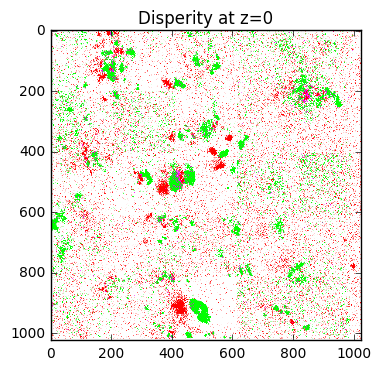

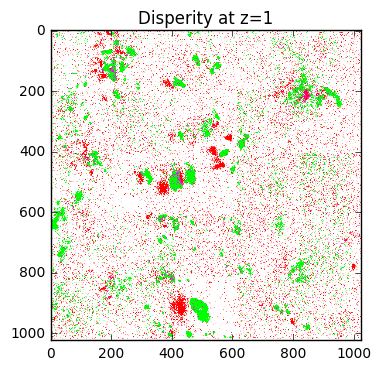

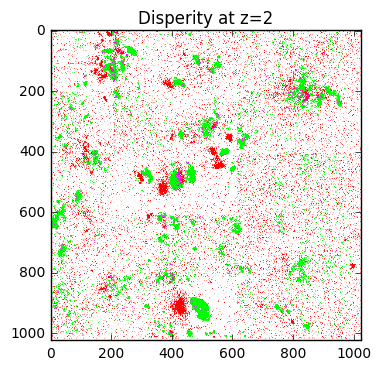

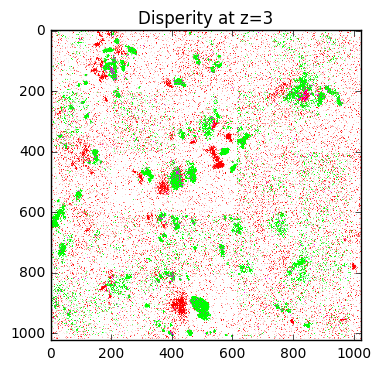

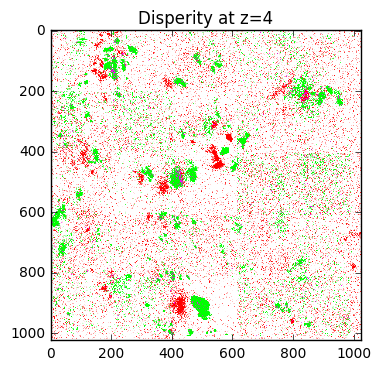

In [35]:
visVolDiff(preproc(tp1Test), preproc(tp2TestReg))

# Rigid Results
The registration definately moves us in the right direction; note the blobs on the bttom of the image (appx 900,500) are much closer than before. The transformation here, I think, is simply not strong enough to align the images. This could be due to a host of reasons:

- Step size too small
- Only 1 iteration of rigid alignment
- Too few samples between images
- Too much noise in input images

Next step is increasing the number of samples. Hopefully this will give the alg a better idea of the large structures of the image, and improve registration.

On the bright side, registration of 5 slices took about 30 seconds, wehereas it took *SUBSTANTIALLY* longer before.

In [41]:
%%time 
SimpleElastix = sitk.SimpleElastix()

SimpleElastix.LogToConsoleOn()

img2 = nib.Nifti1Image(preproc(tp1Test), np.eye(4))
nib.save(img2, 'fixed.nii')
img3 = nib.Nifti1Image(preproc(tp2Test), np.eye(4))
nib.save(img3, 'moving.nii')

SimpleElastix.SetFixedImage(sitk.ReadImage('fixed.nii'))
SimpleElastix.SetMovingImage(sitk.ReadImage('moving.nii'))

pMap = sitk.GetDefaultParameterMap('rigid')
pMap['AutomaticTransformInitialization'] =['true']
pMap['MaximumNumberOfSamplingAttempts'] = ['20']
pMap['RequiredRatioOfValidSamples'] = ['.15']

SimpleElastix.SetParameterMap(pMap)
SimpleElastix.Execute()

0.2
0.4
0.6
0.8
1.0
0.2
0.4
0.6
0.8
1.0
CPU times: user 27.4 s, sys: 344 ms, total: 27.7 s
Wall time: 5.81 s


0.2
0.4
0.6
0.8
1.0
0.2
0.4
0.6
0.8
1.0


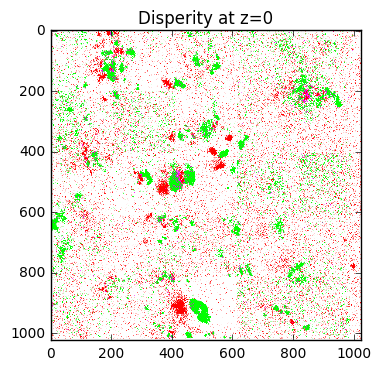

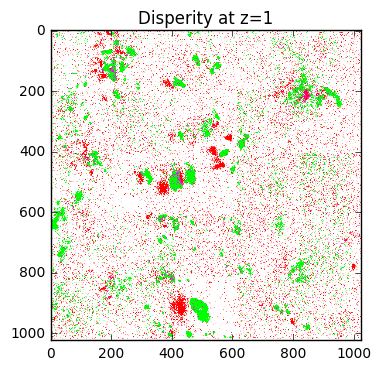

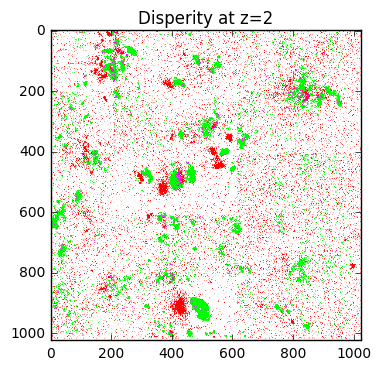

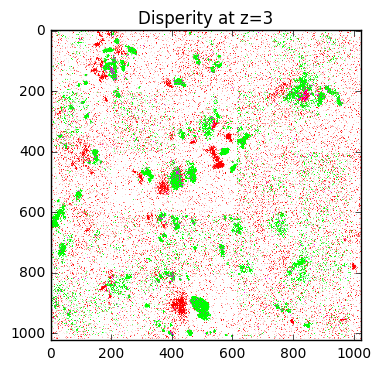

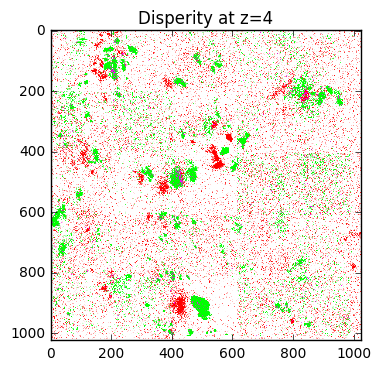

In [42]:
transformParameterMap = SimpleElastix.GetTransformParameterMap()

transImg = sitk.GetImageFromArray(tp2Test)

imageFilter = sitk.ReadTransform('transformComposite.h5')
tp2TestRegImg = sitk.Resample(transImg,imageFilter, sitk.sitkGaussian, sitk.sitkFloat32)
tp2TestReg = sitk.GetArrayFromImage(tp2TestRegImg)

visVolDiff(preproc(tp1Test), preproc(tp2TestReg))

In [11]:
%%time 
SimpleElastix = sitk.SimpleElastix()

SimpleElastix.LogToConsoleOn()

img2 = nib.Nifti1Image(preproc(tp1Test), np.eye(4))
nib.save(img2, 'fixed.nii')
img3 = nib.Nifti1Image(preproc(tp2Test), np.eye(4))
nib.save(img3, 'moving.nii')

SimpleElastix.SetFixedImage(sitk.ReadImage('fixed.nii'))
SimpleElastix.SetMovingImage(sitk.ReadImage('moving.nii'))

pMap = sitk.GetDefaultParameterMap('rigid')
pMap['AutomaticTransformInitialization'] =['true']
pMap['MaximumNumberOfSamplingAttempts'] = ['30']
pMap['RequiredRatioOfValidSamples'] = ['.35']

SimpleElastix.SetParameterMap(pMap)
SimpleElastix.Execute()

0.2
0.4
0.6
0.8
1.0
0.2
0.4
0.6
0.8
1.0


RuntimeError: Exception thrown in SimpleITK SimpleElastix_Execute: /home/bstadt/simpleElastix/SimpleElastix/Code/Elastix/src/sitkSimpleElastixImpl.cxx:208:
sitk::ERROR: 
itk::ExceptionObject (0x59fd940)
Location: "unknown" 
File: /home/bstadt/simpleElastix/build/elastix/src/Core/Main/elxElastixFilter.hxx
Line: 240
Description: itk::ERROR: Self(0x5a65860): Internal elastix error: See elastix log (use LogToConsoleOn() or LogToFileOn()).



Looks like pumping up the number of samples only gets us so far before simple elastix can't handle it.

In [9]:
%%time 
SimpleElastix = sitk.SimpleElastix()

SimpleElastix.LogToConsoleOn()

img2 = nib.Nifti1Image(preproc(tp1Test), np.eye(4))
nib.save(img2, 'fixed.nii')
img3 = nib.Nifti1Image(preproc(tp2Test), np.eye(4))
nib.save(img3, 'moving.nii')

SimpleElastix.SetFixedImage(sitk.ReadImage('fixed.nii'))
SimpleElastix.SetMovingImage(sitk.ReadImage('moving.nii'))

pMap = sitk.GetDefaultParameterMap('affine')
pMap['AutomaticTransformInitialization'] =['true']
pMap['MaximumNumberOfSamplingAttempts'] = ['20']
pMap['RequiredRatioOfValidSamples'] = ['.05']

SimpleElastix.SetParameterMap(pMap)
SimpleElastix.Execute()

0.2
0.4
0.6
0.8
1.0
0.2
0.4
0.6
0.8
1.0
CPU times: user 27.9 s, sys: 812 ms, total: 28.7 s
Wall time: 5.98 s


0.2
0.4
0.6
0.8
1.0
0.2
0.4
0.6
0.8
1.0


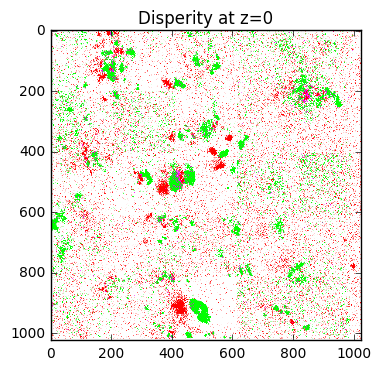

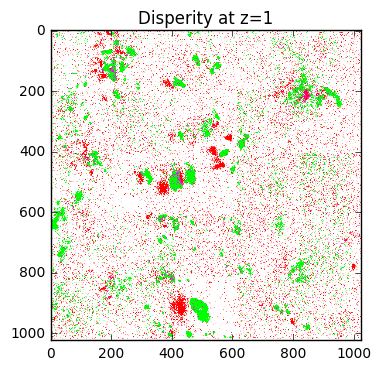

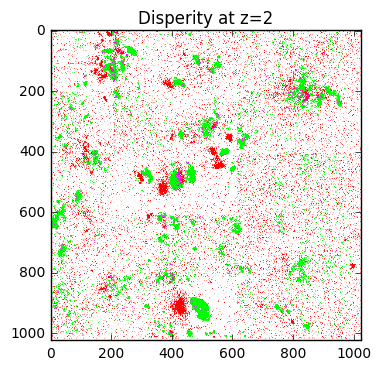

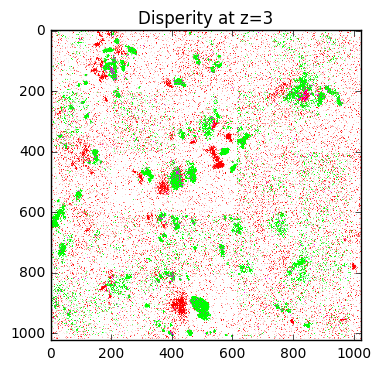

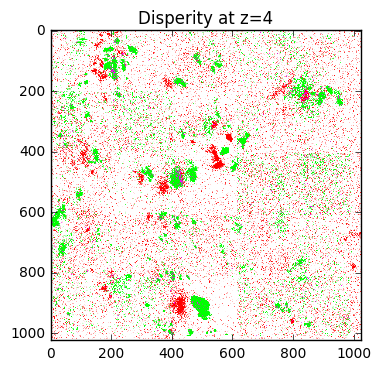

In [10]:
transformParameterMap = SimpleElastix.GetTransformParameterMap()

transImg = sitk.GetImageFromArray(tp2Test)

imageFilter = sitk.ReadTransform('transformComposite.h5')
tp2TestRegImg = sitk.Resample(transImg,imageFilter, sitk.sitkGaussian, sitk.sitkFloat32)
tp2TestReg = sitk.GetArrayFromImage(tp2TestRegImg)

visVolDiff(preproc(tp1Test), preproc(tp2TestReg))

Affine gets us just about as close as rigid. This tells me that neither algorithm has enough iterations to converge - so time to figure out a way to increase that

Time is still looking good though

In [12]:
%%time 
SimpleElastix = sitk.SimpleElastix()

SimpleElastix.LogToConsoleOn()

img2 = nib.Nifti1Image(preproc(tp1Test), np.eye(4))
nib.save(img2, 'fixed.nii')
img3 = nib.Nifti1Image(preproc(tp2Test), np.eye(4))
nib.save(img3, 'moving.nii')

SimpleElastix.SetFixedImage(sitk.ReadImage('fixed.nii'))
SimpleElastix.SetMovingImage(sitk.ReadImage('moving.nii'))

pMap = sitk.GetDefaultParameterMap('rigid')
pMap['AutomaticTransformInitialization'] =['true']
pMap['MaximumNumberOfSamplingAttempts'] = ['20']
pMap['RequiredRatioOfValidSamples'] = ['.05']
pMap['MaximumNumberOfIterations'] = ['100']
SimpleElastix.SetParameterMap(pMap)
SimpleElastix.Execute()

0.2
0.4
0.6
0.8
1.0
0.2
0.4
0.6
0.8
1.0
CPU times: user 16.8 s, sys: 348 ms, total: 17.2 s
Wall time: 4.03 s


0.2
0.4
0.6
0.8
1.0
0.2
0.4
0.6
0.8
1.0


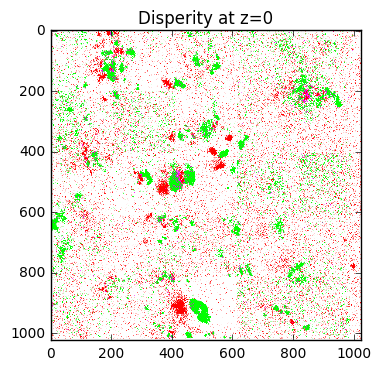

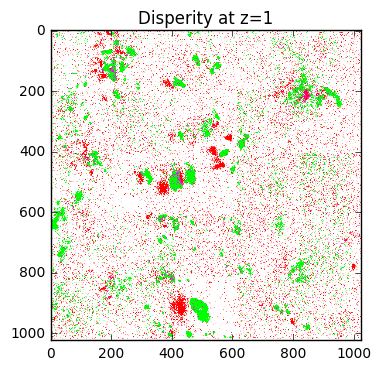

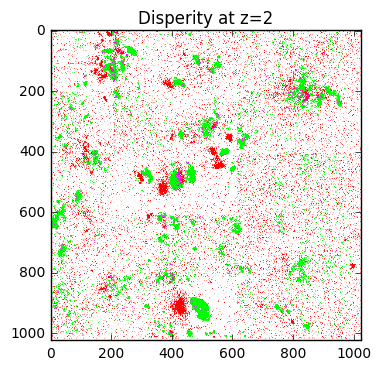

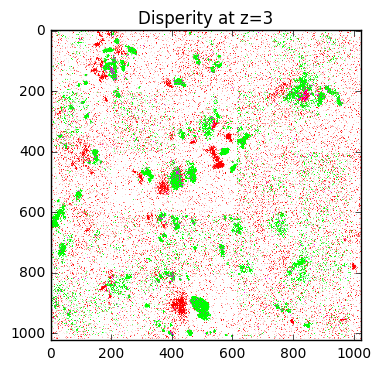

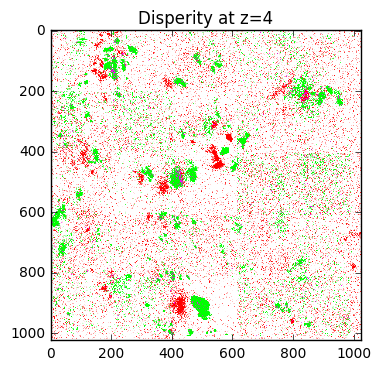

In [13]:
transformParameterMap = SimpleElastix.GetTransformParameterMap()

transImg = sitk.GetImageFromArray(tp2Test)

imageFilter = sitk.ReadTransform('transformComposite.h5')
tp2TestRegImg = sitk.Resample(transImg,imageFilter, sitk.sitkGaussian, sitk.sitkFloat32)
tp2TestReg = sitk.GetArrayFromImage(tp2TestRegImg)

visVolDiff(preproc(tp1Test), preproc(tp2TestReg))

In [14]:
%%time 
SimpleElastix = sitk.SimpleElastix()

SimpleElastix.LogToConsoleOn()

img2 = nib.Nifti1Image(preproc(tp1Test), np.eye(4))
nib.save(img2, 'fixed.nii')
img3 = nib.Nifti1Image(preproc(tp2Test), np.eye(4))
nib.save(img3, 'moving.nii')

SimpleElastix.SetFixedImage(sitk.ReadImage('fixed.nii'))
SimpleElastix.SetMovingImage(sitk.ReadImage('moving.nii'))

pMap = sitk.GetDefaultParameterMap('rigid')
pMap['AutomaticTransformInitialization'] =['true']
pMap['MaximumNumberOfSamplingAttempts'] = ['20']
pMap['RequiredRatioOfValidSamples'] = ['.05']
pMap['MaximumNumberOfIterations'] = ['500']
SimpleElastix.SetParameterMap(pMap)
SimpleElastix.Execute()

0.2
0.4
0.6
0.8
1.0
0.2
0.4
0.6
0.8
1.0
CPU times: user 47 s, sys: 692 ms, total: 47.7 s
Wall time: 9.18 s


0.2
0.4
0.6
0.8
1.0
0.2
0.4
0.6
0.8
1.0


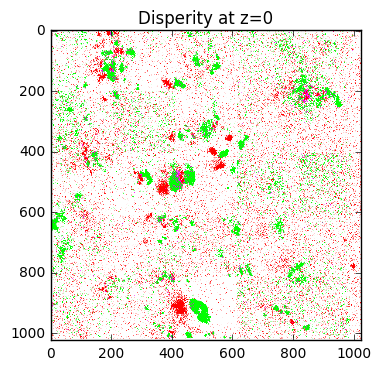

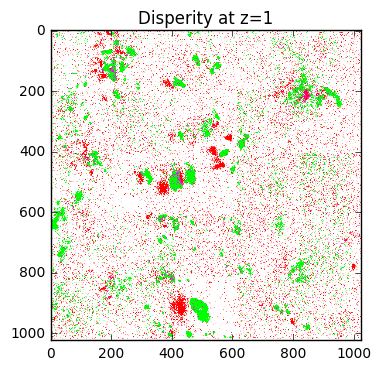

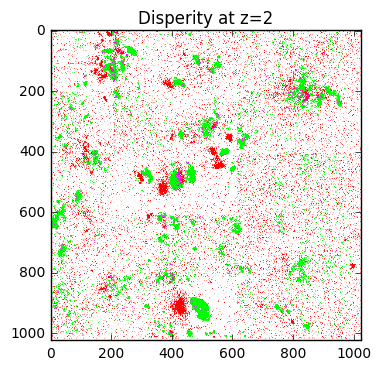

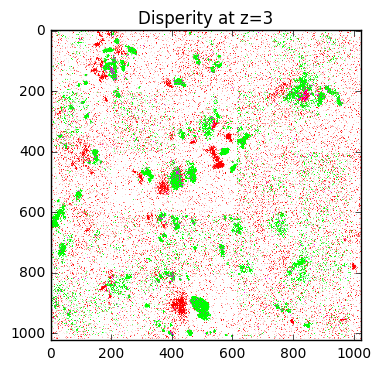

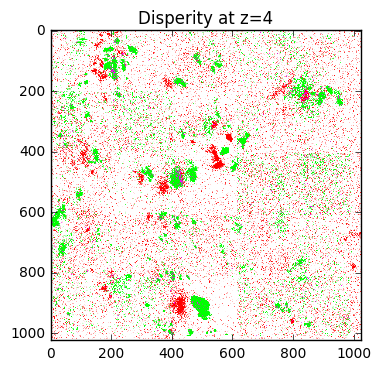

In [15]:
transformParameterMap = SimpleElastix.GetTransformParameterMap()

transImg = sitk.GetImageFromArray(tp2Test)

imageFilter = sitk.ReadTransform('transformComposite.h5')
tp2TestRegImg = sitk.Resample(transImg,imageFilter, sitk.sitkGaussian, sitk.sitkFloat32)
tp2TestReg = sitk.GetArrayFromImage(tp2TestRegImg)

visVolDiff(preproc(tp1Test), preproc(tp2TestReg))

Number of iterations really doesnt change much - this is indicitive of the solver getting stuck in a local minimum. Im going to try to increase the step size in some way.

In [18]:
%%time 
SimpleElastix = sitk.SimpleElastix()

SimpleElastix.LogToConsoleOn()

img2 = nib.Nifti1Image(preproc(tp1Test), np.eye(4))
nib.save(img2, 'fixed.nii')
img3 = nib.Nifti1Image(preproc(tp2Test), np.eye(4))
nib.save(img3, 'moving.nii')

SimpleElastix.SetFixedImage(sitk.ReadImage('fixed.nii'))
SimpleElastix.SetMovingImage(sitk.ReadImage('moving.nii'))

pMap = sitk.GetDefaultParameterMap('rigid')
pMap['AutomaticTransformInitialization'] =['true']
pMap['MaximumNumberOfSamplingAttempts'] = ['20']
pMap['RequiredRatioOfValidSamples'] = ['.05']
pMap['MaximumNumberOfIterations'] = ['100']
pMap['MaximumStepLength'] = ['5.0']
pMap['UseAdaptiveStepSizes'] = ['false']
SimpleElastix.SetParameterMap(pMap)
SimpleElastix.Execute()

0.2
0.4
0.6
0.8
1.0
0.2
0.4
0.6
0.8
1.0


RuntimeError: Exception thrown in SimpleITK SimpleElastix_Execute: /home/bstadt/simpleElastix/SimpleElastix/Code/Elastix/src/sitkSimpleElastixImpl.cxx:208:
sitk::ERROR: 
itk::ExceptionObject (0x5ba1390)
Location: "unknown" 
File: /home/bstadt/simpleElastix/build/elastix/src/Core/Main/elxElastixFilter.hxx
Line: 240
Description: itk::ERROR: Self(0xbb6da40): Internal elastix error: See elastix log (use LogToConsoleOn() or LogToFileOn()).



Changing the step length keeps crashing SimpleITK... I guess that means that It isn't a valid approach. Maybe, instead, change preprocessing so there is less noise for the registration to grab on to?

In [7]:
def preproc2(img):
    binImg = adaptiveThreshold(img, 5, 5)
    outImg = np.stack([cv2.erode(sub, None, 1) for sub in binImg])
    return outImg

0.2
0.4
0.6
0.8
1.0
0.2
0.4
0.6
0.8
1.0


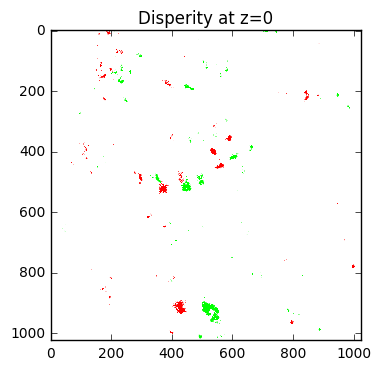

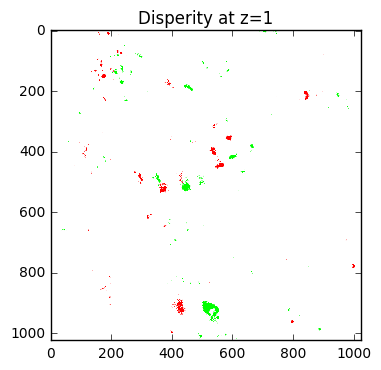

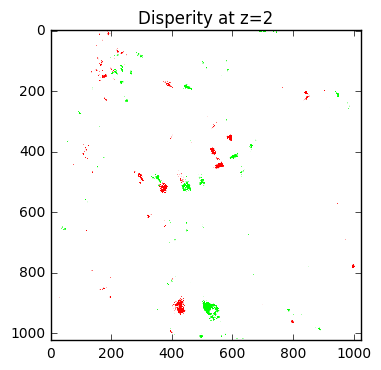

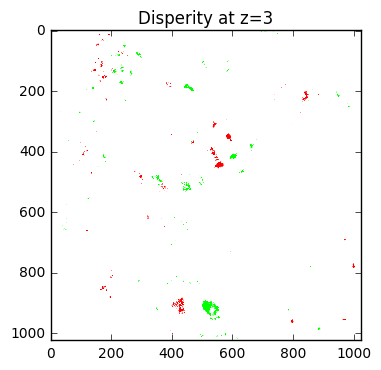

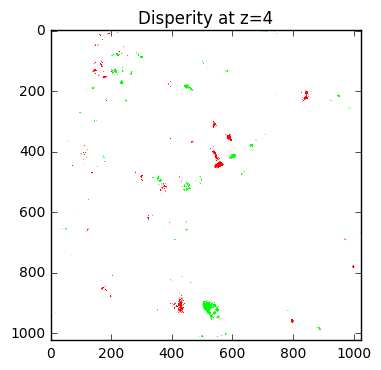

In [16]:
visVolDiff(preproc2(tp1Test), preproc2(tp2Test))

Ok super much less noise for the algorthm to grab on to, with a bunch of clear landmarks still visible. 

In [17]:
%%time 
SimpleElastix = sitk.SimpleElastix()

SimpleElastix.LogToConsoleOn()

img2 = nib.Nifti1Image(preproc2(tp1Test), np.eye(4))
nib.save(img2, 'fixed.nii')
img3 = nib.Nifti1Image(preproc2(tp2Test), np.eye(4))
nib.save(img3, 'moving.nii')

SimpleElastix.SetFixedImage(sitk.ReadImage('fixed.nii'))
SimpleElastix.SetMovingImage(sitk.ReadImage('moving.nii'))

pMap = sitk.GetDefaultParameterMap('rigid')
pMap['AutomaticTransformInitialization'] =['true']
pMap['MaximumNumberOfSamplingAttempts'] = ['200']
pMap['RequiredRatioOfValidSamples'] = ['.05']
pMap['MaximumNumberOfIterations'] = ['100']
SimpleElastix.SetParameterMap(pMap)
SimpleElastix.Execute()

0.2
0.4
0.6
0.8
1.0
0.2
0.4
0.6
0.8
1.0
CPU times: user 14.4 s, sys: 620 ms, total: 15 s
Wall time: 3.69 s


0.2
0.4
0.6
0.8
1.0
0.2
0.4
0.6
0.8
1.0


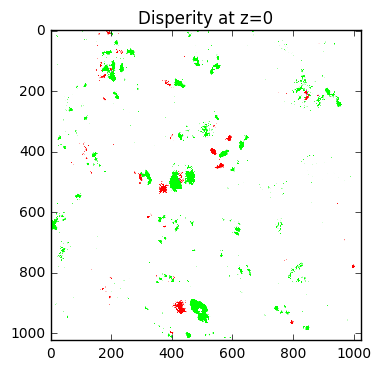

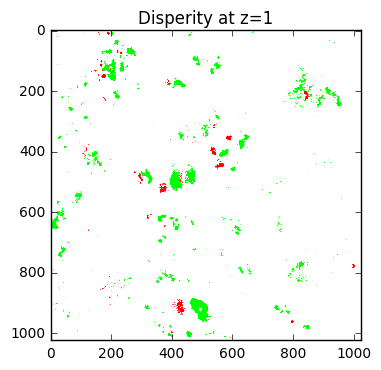

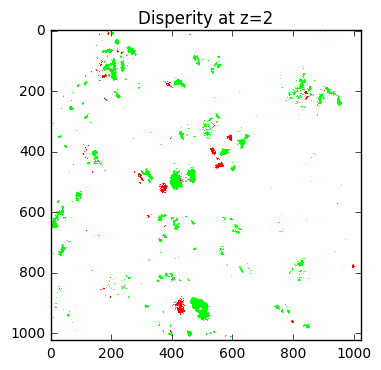

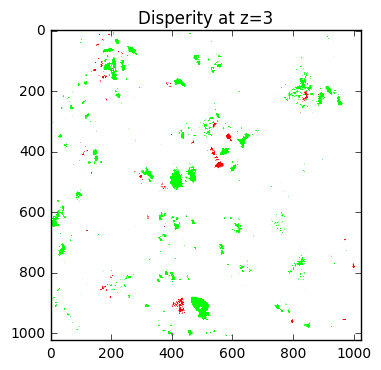

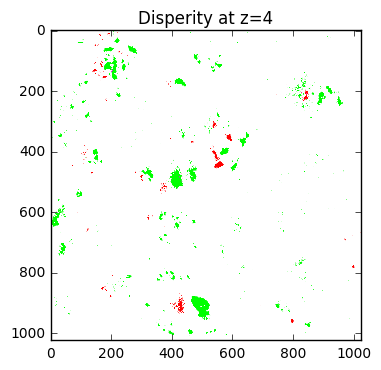

In [19]:
transformParameterMap = SimpleElastix.GetTransformParameterMap()

transImg = sitk.GetImageFromArray(tp2Test)

imageFilter = sitk.ReadTransform('transformComposite.h5')
tp2TestRegImg = sitk.Resample(transImg,imageFilter, sitk.sitkGaussian, sitk.sitkFloat32)
tp2TestReg = sitk.GetArrayFromImage(tp2TestRegImg)

visVolDiff(preproc2(tp1Test), preproc2(tp2TestReg))

Ok so I got super confused at this point for a while. The upper right hand corner of the image does give a clue though - notice how the green is moved to surround the red? Maybe this is the optimal solution for mutul information loss, but not for us. If I change the loss to l2, maybe things will turn out better. Worth a shot.

In [8]:
%%time 
SimpleElastix = sitk.SimpleElastix()

SimpleElastix.LogToConsoleOn()

img2 = nib.Nifti1Image(preproc(tp1Test), np.eye(4))
nib.save(img2, 'fixed.nii')
img3 = nib.Nifti1Image(preproc(tp2Test), np.eye(4))
nib.save(img3, 'moving.nii')

SimpleElastix.SetFixedImage(sitk.ReadImage('fixed.nii'))
SimpleElastix.SetMovingImage(sitk.ReadImage('moving.nii'))

pMap = sitk.GetDefaultParameterMap('rigid')
pMap['AutomaticTransformInitialization'] =['true']
pMap['MaximumNumberOfSamplingAttempts'] = ['200']
pMap['CheckNumberOfSamples'] = ['false']
pMap['MaximumNumberOfIterations'] = ['100']
pMap['Metric'] = ['AdvancedNormalizedCorrelation']
SimpleElastix.SetParameterMap(pMap)
SimpleElastix.Execute()

0.2
0.4
0.6
0.8
1.0
0.2
0.4
0.6
0.8
1.0
CPU times: user 14 s, sys: 668 ms, total: 14.7 s
Wall time: 3.21 s


0.2
0.4
0.6
0.8
1.0
0.2
0.4
0.6
0.8
1.0


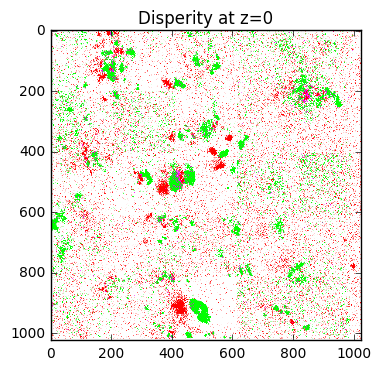

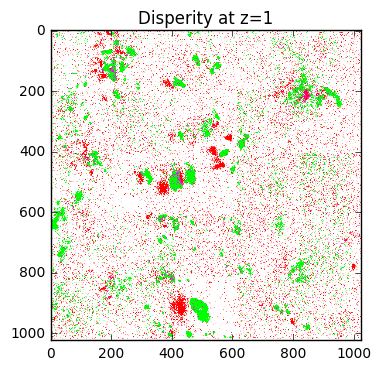

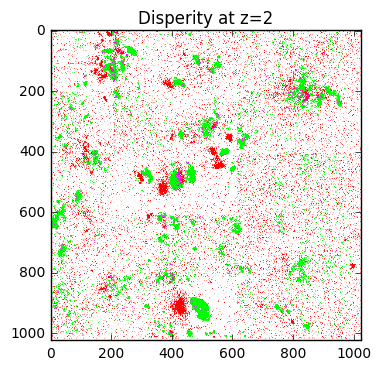

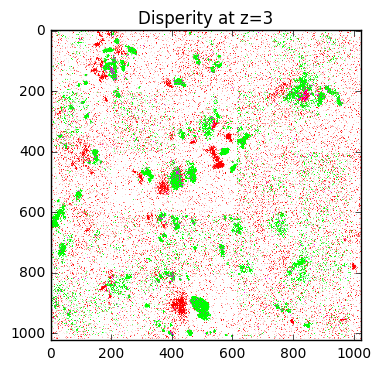

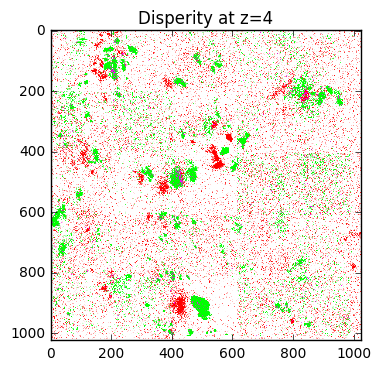

In [10]:
transformParameterMap = SimpleElastix.GetTransformParameterMap()

transImg = sitk.GetImageFromArray(tp2Test)

imageFilter = sitk.ReadTransform('transformComposite.h5')
tp2TestRegImg = sitk.Resample(transImg,imageFilter, sitk.sitkGaussian, sitk.sitkFloat32)
tp2TestReg = sitk.GetArrayFromImage(tp2TestRegImg)

visVolDiff(preproc(tp1Test), preproc(tp2TestReg))

In [14]:
%%time 
SimpleElastix = sitk.SimpleElastix()

SimpleElastix.LogToConsoleOn()

img2 = nib.Nifti1Image(preproc(tp1Test), np.eye(4))
nib.save(img2, 'fixed.nii')
img3 = nib.Nifti1Image(preproc(tp2Test), np.eye(4))
nib.save(img3, 'moving.nii')

SimpleElastix.SetFixedImage(sitk.ReadImage('fixed.nii'))
SimpleElastix.SetMovingImage(sitk.ReadImage('moving.nii'))

pMap = sitk.GetDefaultParameterMap('rigid')
pMap['AutomaticTransformInitialization'] =['true']
pMap['MaximumNumberOfSamplingAttempts'] = ['200']
pMap['CheckNumberOfSamples'] = ['false']
pMap['MaximumNumberOfIterations'] = ['100']
pMap['NumberOfSpatialSamples'] = ['1000000']
pMap['Metric'] = ['AdvancedNormalizedCorrelation']
SimpleElastix.SetParameterMap(pMap)
SimpleElastix.Execute()

0.2
0.4
0.6
0.8
1.0
0.2
0.4
0.6
0.8
1.0
CPU times: user 3min 2s, sys: 396 ms, total: 3min 2s
Wall time: 1min 15s


In [16]:
%%time 
SimpleElastix = sitk.SimpleElastix()

SimpleElastix.LogToConsoleOn()

img2 = nib.Nifti1Image(preproc2(tp1Test), np.eye(4))
nib.save(img2, 'fixed.nii')
img3 = nib.Nifti1Image(preproc2(tp2Test), np.eye(4))
nib.save(img3, 'moving.nii')

SimpleElastix.SetFixedImage(sitk.ReadImage('fixed.nii'))
SimpleElastix.SetMovingImage(sitk.ReadImage('moving.nii'))

pMap = sitk.GetDefaultParameterMap('rigid')
pMap['AutomaticTransformInitialization'] =['true']
pMap['MaximumNumberOfSamplingAttempts'] = ['200']
pMap['RequiredRatioOfValidSamples'] = ['.05']
pMap['MaximumNumberOfIterations'] = ['500']

pMap['Metric'] = ['AdvancedMeanSquares']

SimpleElastix.SetParameterMap(pMap)
SimpleElastix.Execute()

0.2
0.4
0.6
0.8
1.0
0.2
0.4
0.6
0.8
1.0
CPU times: user 27.7 s, sys: 788 ms, total: 28.5 s
Wall time: 5.78 s


0.2
0.4
0.6
0.8
1.0
0.2
0.4
0.6
0.8
1.0


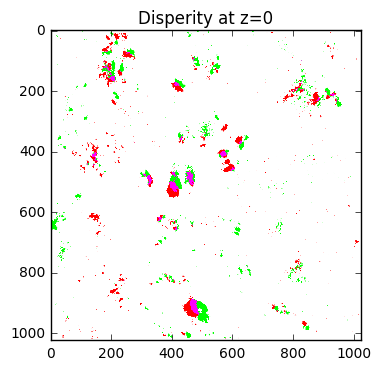

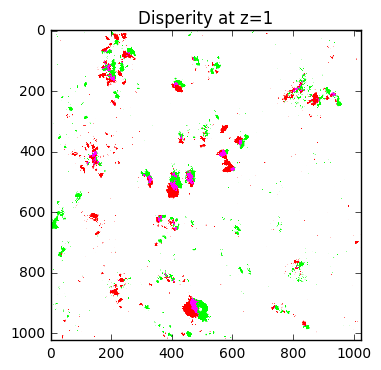

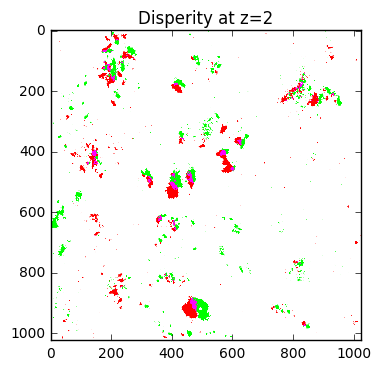

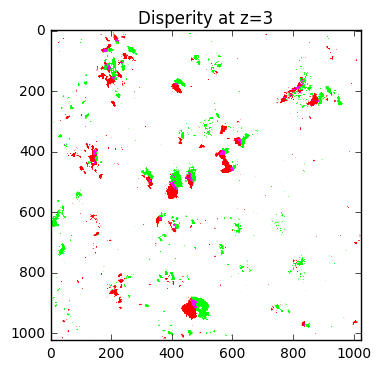

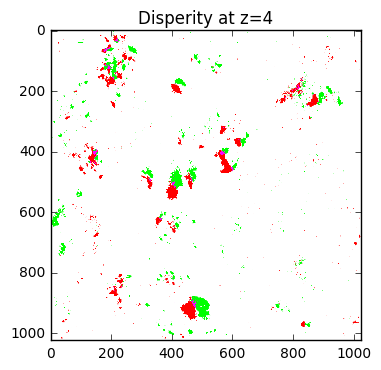

In [22]:
transformParameterMap = SimpleElastix.GetTransformParameterMap()

transImg = sitk.GetImageFromArray(tp2Test)
baseImg = sitk.GetImageFromArray(tp1Test)

imageFilter = sitk.ReadTransform('transformComposite.h5')
tp2TestRegImg = sitk.Resample(transImg,imageFilter, sitk.sitkGaussian, sitk.sitkFloat32)
tp2TestReg = sitk.GetArrayFromImage(tp2TestRegImg)

imageFilter = sitk.ReadTransform('transformInverseComposite.h5')
tp1TestRegImg = sitk.Resample(baseImg,imageFilter, sitk.sitkGaussian, sitk.sitkFloat32)
tp1TestReg = sitk.GetArrayFromImage(tp1TestRegImg)

visVolDiff(preproc2(tp1TestReg), preproc2(tp2TestReg))

# Progress!
Looks like changing to l2 loss is definately the way to go. This, combined with the preprocessing erosion, has yielded the best results so far. And the entire transform remains fast at about a second per slice. Time to amp up the number of samples to see if precision increases

In [23]:
%%time 
SimpleElastix = sitk.SimpleElastix()

SimpleElastix.LogToConsoleOn()

img2 = nib.Nifti1Image(preproc2(tp1Test), np.eye(4))
nib.save(img2, 'fixed.nii')
img3 = nib.Nifti1Image(preproc2(tp2Test), np.eye(4))
nib.save(img3, 'moving.nii')

SimpleElastix.SetFixedImage(sitk.ReadImage('fixed.nii'))
SimpleElastix.SetMovingImage(sitk.ReadImage('moving.nii'))

pMap = sitk.GetDefaultParameterMap('rigid')
pMap['AutomaticTransformInitialization'] =['true']
pMap['MaximumNumberOfSamplingAttempts'] = ['200']
pMap['RequiredRatioOfValidSamples'] = ['.05']
pMap['MaximumNumberOfIterations'] = ['500']
pMap['NumberOfSpatialSamples'] = ['100000']
pMap['Metric'] = ['AdvancedMeanSquares']

SimpleElastix.SetParameterMap(pMap)
SimpleElastix.Execute()

0.2
0.4
0.6
0.8
1.0
0.2
0.4
0.6
0.8
1.0
CPU times: user 1min 46s, sys: 1.52 s, total: 1min 48s
Wall time: 47.9 s


0.2
0.4
0.6
0.8
1.0
0.2
0.4
0.6
0.8
1.0


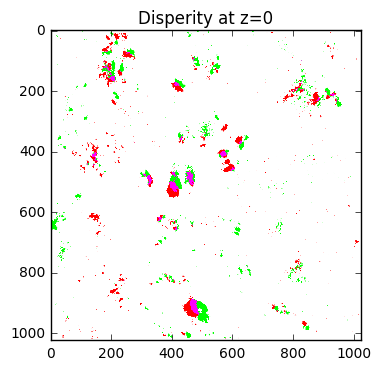

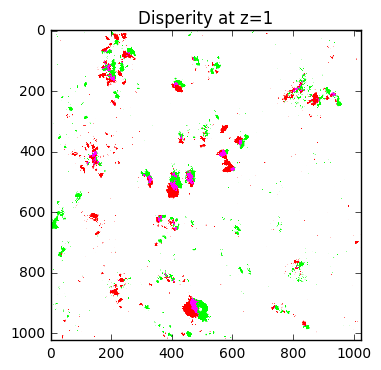

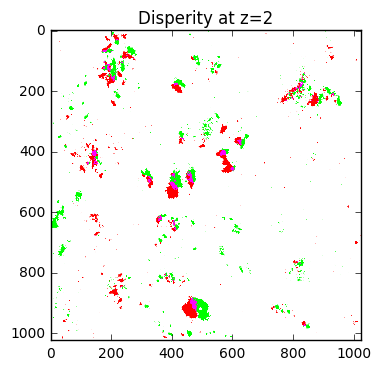

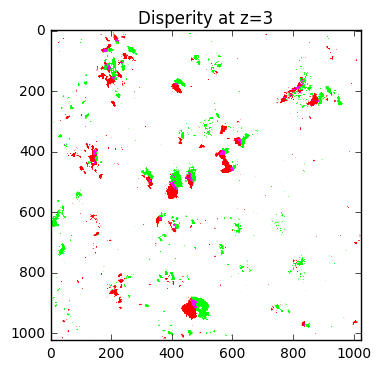

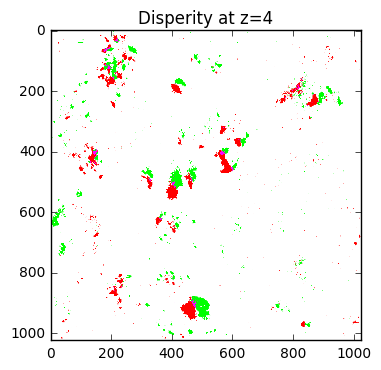

In [24]:
transformParameterMap = SimpleElastix.GetTransformParameterMap()

transImg = sitk.GetImageFromArray(tp2Test)
baseImg = sitk.GetImageFromArray(tp1Test)

imageFilter = sitk.ReadTransform('transformComposite.h5')
tp2TestRegImg = sitk.Resample(transImg,imageFilter, sitk.sitkGaussian, sitk.sitkFloat32)
tp2TestReg = sitk.GetArrayFromImage(tp2TestRegImg)

imageFilter = sitk.ReadTransform('transformInverseComposite.h5')
tp1TestRegImg = sitk.Resample(baseImg,imageFilter, sitk.sitkGaussian, sitk.sitkFloat32)
tp1TestReg = sitk.GetArrayFromImage(tp1TestRegImg)

visVolDiff(preproc2(tp1TestReg), preproc2(tp2TestReg))

In [25]:
%%time 
SimpleElastix = sitk.SimpleElastix()

SimpleElastix.LogToConsoleOn()

img2 = nib.Nifti1Image(preproc2(tp1Test), np.eye(4))
nib.save(img2, 'fixed.nii')
img3 = nib.Nifti1Image(preproc2(tp2Test), np.eye(4))
nib.save(img3, 'moving.nii')

SimpleElastix.SetFixedImage(sitk.ReadImage('fixed.nii'))
SimpleElastix.SetMovingImage(sitk.ReadImage('moving.nii'))

pMap = sitk.GetDefaultParameterMap('affine')
pMap['AutomaticTransformInitialization'] =['true']
pMap['MaximumNumberOfSamplingAttempts'] = ['200']
pMap['RequiredRatioOfValidSamples'] = ['.05']
pMap['MaximumNumberOfIterations'] = ['500']
pMap['NumberOfSpatialSamples'] = ['100000']
pMap['Metric'] = ['AdvancedMeanSquares']

SimpleElastix.SetParameterMap(pMap)
SimpleElastix.Execute()

0.2
0.4
0.6
0.8
1.0
0.2
0.4
0.6
0.8
1.0
CPU times: user 1min 46s, sys: 1.61 s, total: 1min 48s
Wall time: 48.4 s


0.2
0.4
0.6
0.8
1.0
0.2
0.4
0.6
0.8
1.0


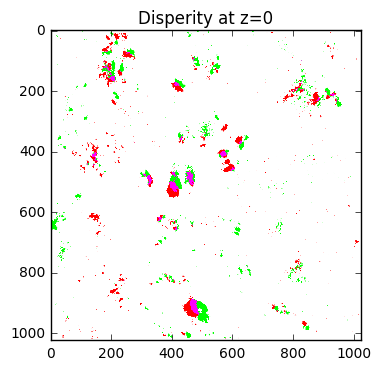

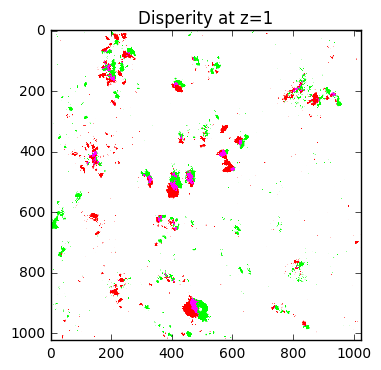

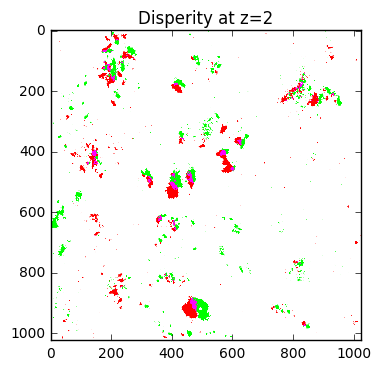

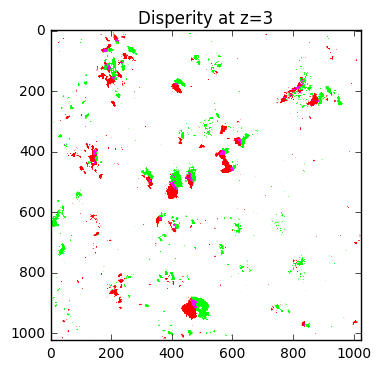

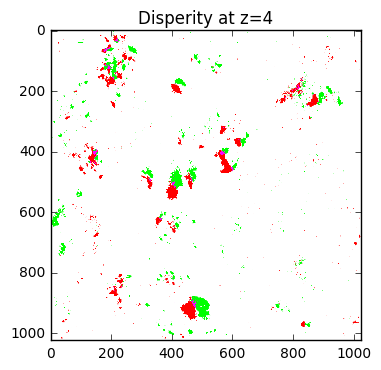

In [32]:
transformParameterMap = SimpleElastix.GetTransformParameterMap()

transImg = sitk.GetImageFromArray(tp2Test)
baseImg = sitk.GetImageFromArray(tp1Test)

imageFilter = sitk.ReadTransform('transformComposite.h5')
tp2TestRegImg = sitk.Resample(transImg,imageFilter, sitk.sitkGaussian, sitk.sitkFloat32)
tp2TestReg = sitk.GetArrayFromImage(tp2TestRegImg)

imageFilter = sitk.ReadTransform('transformInverseComposite.h5')
tp1TestRegImg = sitk.Resample(baseImg,imageFilter, sitk.sitkGaussian, sitk.sitkFloat32)
tp1TestReg = sitk.GetArrayFromImage(tp1TestRegImg)

visVolDiff(preproc2(tp1TestReg), preproc2(tp2TestReg))

In [55]:
%%time 
SimpleElastix = sitk.SimpleElastix()

SimpleElastix.LogToConsoleOn()

img2 = nib.Nifti1Image(preproc2(tp1Test), np.eye(4))
nib.save(img2, 'fixed.nii')
img3 = nib.Nifti1Image(preproc2(tp2Test), np.eye(4))
nib.save(img3, 'moving.nii')

SimpleElastix.SetFixedImage(sitk.ReadImage('fixed.nii'))
SimpleElastix.SetMovingImage(sitk.ReadImage('moving.nii'))

pMap = sitk.GetDefaultParameterMap('bspline')
pMap['AutomaticTransformInitialization'] =['true']
pMap['MaximumNumberOfSamplingAttempts'] = ['500']
pMap['RequiredRatioOfValidSamples'] = ['.05']
pMap['MaximumNumberOfIterations'] = ['500']
pMap['Metric'] = ['AdvancedMeanSquares']

SimpleElastix.SetParameterMap(pMap)
SimpleElastix.Execute()

0.2
0.4
0.6
0.8
1.0
0.2
0.4
0.6
0.8
1.0
CPU times: user 2min 36s, sys: 1.8 s, total: 2min 37s
Wall time: 1min 38s


0.2
0.4
0.6
0.8
1.0
0.2
0.4
0.6
0.8
1.0


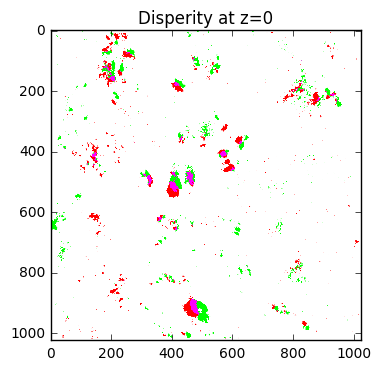

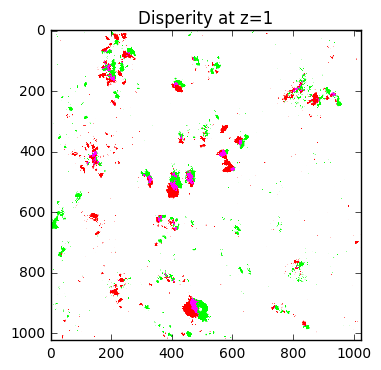

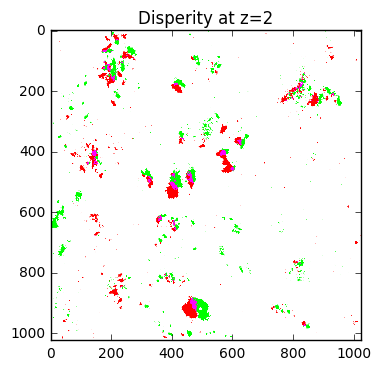

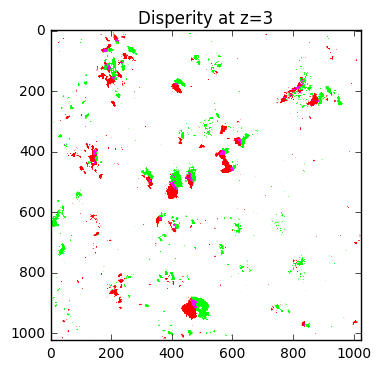

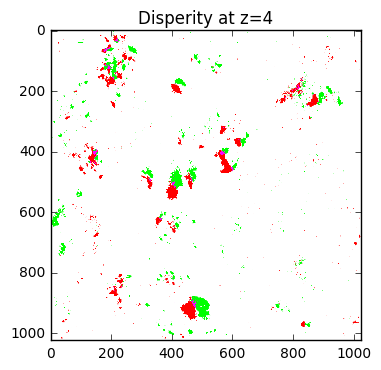

In [57]:
transformParameterMap = SimpleElastix.GetTransformParameterMap()

transImg = sitk.GetImageFromArray(tp2Test)
baseImg = sitk.GetImageFromArray(tp1Test)

imageFilter = sitk.ReadTransform('transformComposite.h5')
tp2TestRegImg = sitk.Resample(transImg,imageFilter, sitk.sitkGaussian, sitk.sitkFloat32)
tp2TestReg = sitk.GetArrayFromImage(tp2TestRegImg)

imageFilter = sitk.ReadTransform('transformInverseComposite.h5')
tp1TestRegImg = sitk.Resample(baseImg,imageFilter, sitk.sitkGaussian, sitk.sitkFloat32)
tp1TestReg = sitk.GetArrayFromImage(tp1TestRegImg)

visVolDiff(preproc2(tp1TestReg), preproc2(tp2TestReg))

In [58]:
outImg = sitk.GetArrayFromImage(SimpleElastix.GetResultImage())

In [59]:
out = np.rollaxis(outImg, 2, 0)

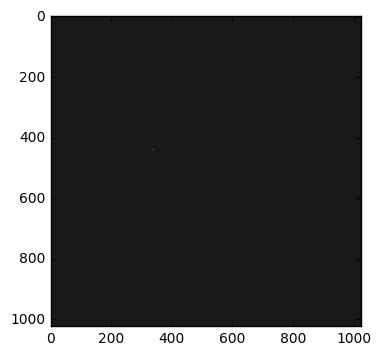

In [60]:
plt.figure()
plt.imshow(out[2], cmap='gray')
plt.show()

# This is awkward
It seems like through the testing I have not been extracting the transformations correctly. Above is the reported disperity from the transform, where white indicates unregistered portions of the image.

See how little white there is? And see how my version has a bunch of disperity? That means I am extracting the transformation wrong.

On the bright side, this means that things are working!

Time to retry rigid with the same stratgy

In [17]:
%%time 
SimpleElastix = sitk.SimpleElastix()

SimpleElastix.LogToConsoleOn()

img2 = nib.Nifti1Image(preproc(tp1Test), np.eye(4))
nib.save(img2, 'fixed.nii')
img3 = nib.Nifti1Image(preproc(tp2Test), np.eye(4))
nib.save(img3, 'moving.nii')

SimpleElastix.SetFixedImage(sitk.ReadImage('fixed.nii'))
SimpleElastix.SetMovingImage(sitk.ReadImage('moving.nii'))

pMap = sitk.GetDefaultParameterMap('rigid')
pMap['AutomaticTransformInitialization'] =['true']
pMap['MaximumNumberOfSamplingAttempts'] = ['200']
pMap['RequiredRatioOfValidSamples'] = ['.05']
pMap['WriteCompositeTransform'] = ['true']

SimpleElastix.SetParameterMap(pMap)
SimpleElastix.Execute()

0.2
0.4
0.6
0.8
1.0
0.2
0.4
0.6
0.8
1.0
CPU times: user 27.3 s, sys: 760 ms, total: 28 s
Wall time: 5.8 s


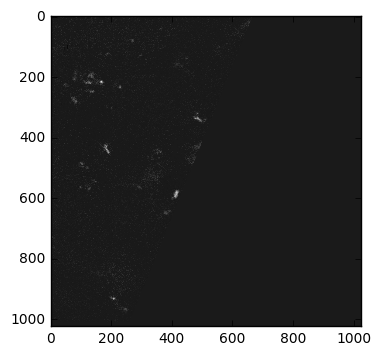

In [62]:
outImg = sitk.GetArrayFromImage(SimpleElastix.GetResultImage())
out = np.rollaxis(outImg, 2, 0)
plt.figure()
plt.imshow(out[2], cmap='gray')
plt.show()

In [25]:
%%time 
SimpleElastix = sitk.SimpleElastix()

SimpleElastix.LogToConsoleOn()

img2 = nib.Nifti1Image(preproc(tp1Test), np.eye(4))
nib.save(img2, 'fixed.nii')
img3 = nib.Nifti1Image(preproc(tp2Test), np.eye(4))
nib.save(img3, 'moving.nii')

SimpleElastix.SetFixedImage(sitk.ReadImage('fixed.nii'))
SimpleElastix.SetMovingImage(sitk.ReadImage('moving.nii'))

pMap = sitk.GetDefaultParameterMap('rigid')
pMap['AutomaticTransformInitialization'] =['true']
pMap['MaximumNumberOfSamplingAttempts'] = ['200']
pMap['RequiredRatioOfValidSamples'] = ['.05']
pMap['WriteCompositeTransform'] = ['true']

SimpleElastix.SetParameterMap(pMap)
SimpleElastix.Execute()

0.2
0.4
0.6
0.8
1.0
0.2
0.4
0.6
0.8
1.0
CPU times: user 28 s, sys: 660 ms, total: 28.6 s
Wall time: 6 s


0.2
0.4
0.6
0.8
1.0
0.2
0.4
0.6
0.8
1.0


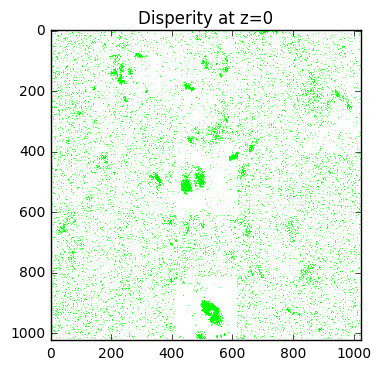

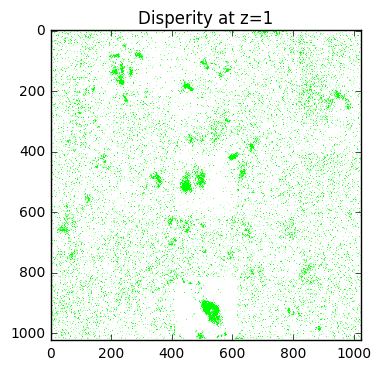

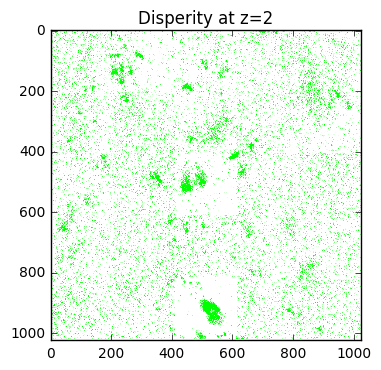

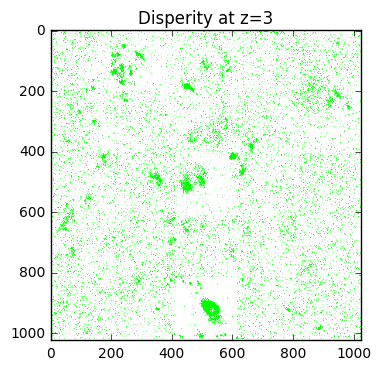

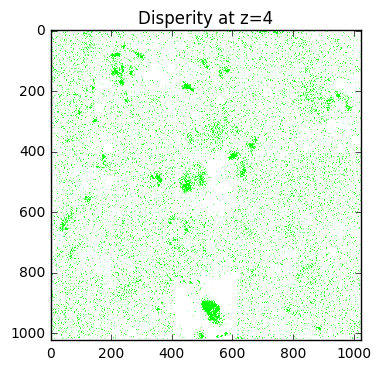

In [41]:
transformParameterMap = SimpleElastix.GetTransformParameterMap()

imgFilter = sitk.SimpleTransformix()
imgFilter.SetTransformParameterMap(transformParameterMap)
imgFilter.SetMovingImage(sitk.GetImageFromArray(tp1Test))
imgFilter.Execute()

tp1RegImg = imgFilter.GetResultImage()
tp1TestReg = sitk.GetArrayFromImage(tp1RegImg)
tp1TestReg = np.rollaxis(tp1TestReg, 2, 0)
visVolDiff(preproc(tp1TestReg), preproc(tp2Test))

In [43]:
%%time 
SimpleElastix = sitk.SimpleElastix()

SimpleElastix.LogToConsoleOn()

img2 = nib.Nifti1Image(preproc(tp1ChanList[1]), np.eye(4))
nib.save(img2, 'fixed.nii')
img3 = nib.Nifti1Image(preproc(tp2ChanList[1]), np.eye(4))
nib.save(img3, 'moving.nii')

SimpleElastix.SetFixedImage(sitk.ReadImage('fixed.nii'))
SimpleElastix.SetMovingImage(sitk.ReadImage('moving.nii'))

pMap = sitk.GetDefaultParameterMap('rigid')
pMap['AutomaticTransformInitialization'] =['true']
pMap['MaximumNumberOfSamplingAttempts'] = ['200']
pMap['RequiredRatioOfValidSamples'] = ['.05']
pMap['WriteCompositeTransform'] = ['true']

SimpleElastix.SetParameterMap(pMap)
SimpleElastix.Execute()

0.00357142857143
0.00714285714286
0.0107142857143
0.0142857142857
0.0178571428571
0.0214285714286
0.025
0.0285714285714
0.0321428571429
0.0357142857143
0.0392857142857
0.0428571428571
0.0464285714286
0.05
0.0535714285714
0.0571428571429
0.0607142857143
0.0642857142857
0.0678571428571
0.0714285714286
0.075
0.0785714285714
0.0821428571429
0.0857142857143
0.0892857142857
0.0928571428571
0.0964285714286
0.1
0.103571428571
0.107142857143
0.110714285714
0.114285714286
0.117857142857
0.121428571429
0.125
0.128571428571
0.132142857143
0.135714285714
0.139285714286
0.142857142857
0.146428571429
0.15
0.153571428571
0.157142857143
0.160714285714
0.164285714286
0.167857142857
0.171428571429
0.175
0.178571428571
0.182142857143
0.185714285714
0.189285714286
0.192857142857
0.196428571429
0.2
0.203571428571
0.207142857143
0.210714285714
0.214285714286
0.217857142857
0.221428571429
0.225
0.228571428571
0.232142857143
0.235714285714
0.239285714286
0.242857142857
0.246428571429
0.25
0.253571428571
0.2571

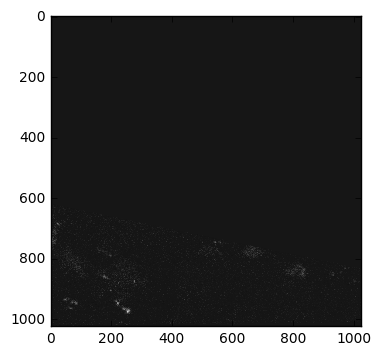

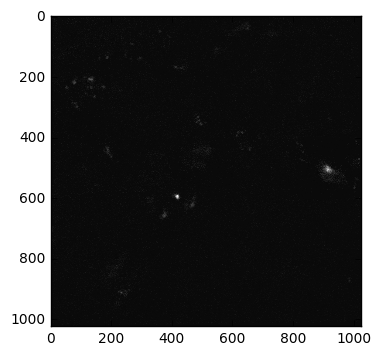

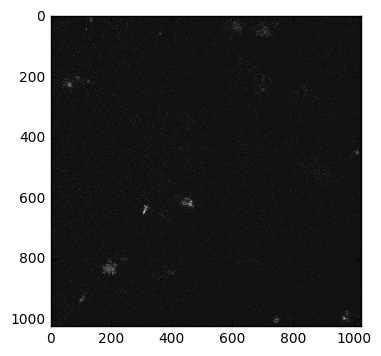

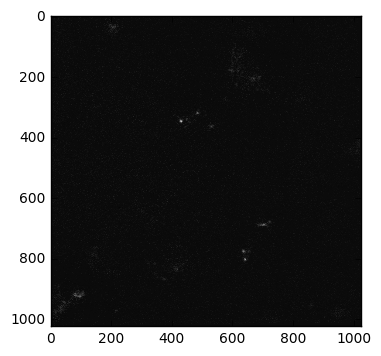

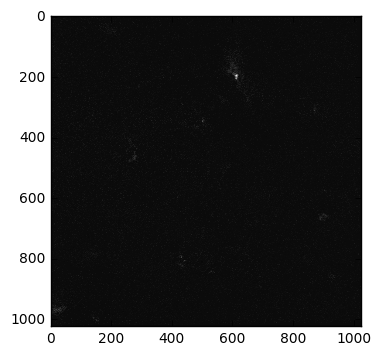

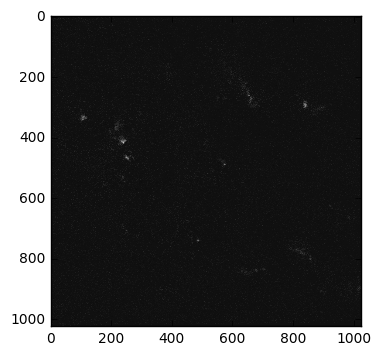

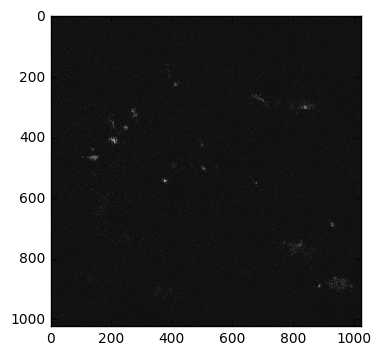

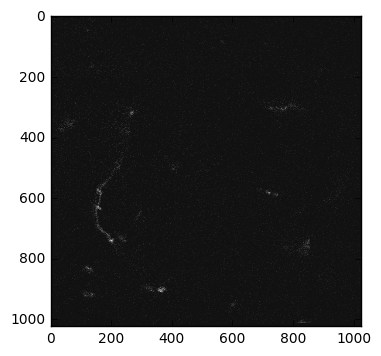

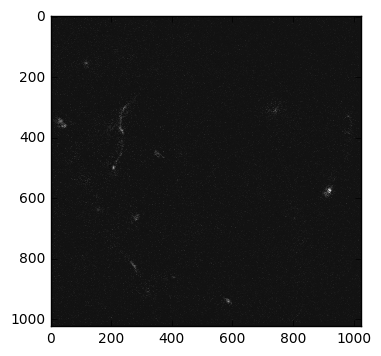

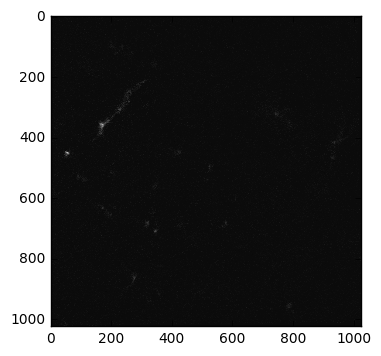

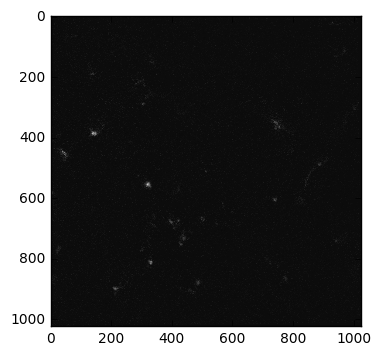

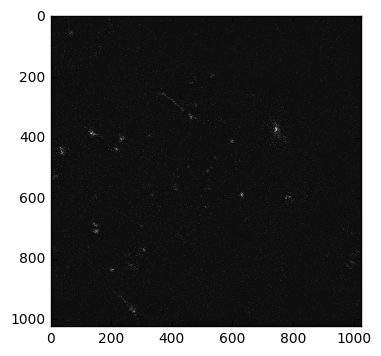

In [46]:
outImg = sitk.GetArrayFromImage(SimpleElastix.GetResultImage())
out = np.rollaxis(outImg, 2, 0)
for idx in range(0, out.shape[0], 25):
    plt.figure()
    plt.imshow(out[idx], cmap='gray')
    plt.title('Disperity')
    plt.show()

    plt.figure()
    plt.imshow(tp1ChanList[1][idx], cmap='gray')
    plt.title('Tp1')
    plt.show()
    
    plt.figure()
    plt.imshow(tp2ChanList[1][idx], cmap='gray')
    plt.title('Tp2')
    plt.show()
    
    print '\n'
    print '\n'

    print '\n'
